# Extract Shadow and Sun Masks from Near-IR

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Veggie-Forest.ipynb)

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
    !mkdir results
else:
    path = '.'
    params = ''

In [2]:
import timeit
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.exposure import histogram
from skimage.filters import rank, apply_hysteresis_threshold
from skimage.color import rgb2lab, lab2rgb, rgb2hsv
from sklearn.ensemble import RandomForestClassifier

In [3]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

# Make a mask

The shadows show up clearly in the Near-IR band. Let's try thresholding that to make a mask.

Text(0, 0.5, 'pixels')

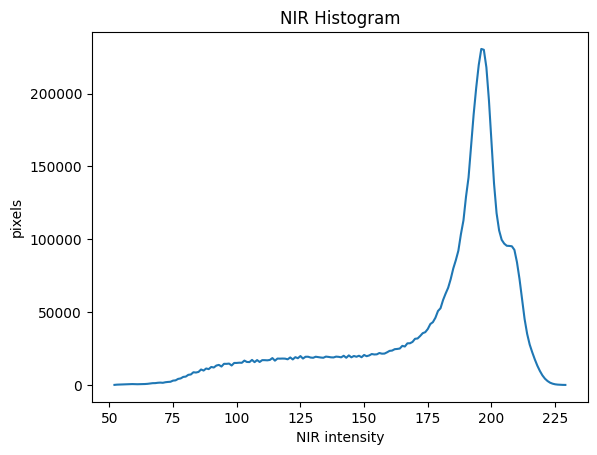

In [4]:
fig, ax = plt.subplots(1, 1)

V_hist, V_centers = histogram(rgb[3,:,:], nbins=256)
ax.plot(V_centers, V_hist)
ax.set_title("NIR Histogram")
ax.set_xlabel('NIR intensity')
ax.set_ylabel('pixels')

## Mask shade pixels

In [5]:
# the shade pixels are True and sunlight pixels are False
# shade = (rgb[3,:,:] > 75) & (rgb[3,:,:] < 110)
_shade = ~apply_hysteresis_threshold(rgb[3,:,:], 130, 160)
water = apply_hysteresis_threshold(1./rgb[3,:,:], 1./80., 1./63.)
shade = morphology.binary_closing((_shade & ~water), morphology.disk(2, dtype=bool))

## Make sunlit mask for pixels adjacent to shade pixels

In [6]:
_sunlit = np.zeros_like(shade)

# roll west, south, north to capture the shadow direction
for i in np.arange(1, 9):
    # produces same number pixels either way
    # _sunlit = np.maximum(_sunlit, (np.roll(shade, -i, axis=1) ^ np.roll(shade, i, axis=0) ^ np.roll(shade, -i, axis=0)))
    # _sunlit += (np.roll(shade, -i, axis=1) ^ np.roll(shade, i, axis=0) ^ np.roll(shade, -i, axis=0))
    _sunlit += (np.roll(shade, -i, axis=1))

_sunlit += np.roll(_sunlit, 1, axis=0)
_sunlit += np.roll(_sunlit, -1, axis=0)

sunlit = (_sunlit & ~shade & ~(rgb[3,:,:] < 120))

In [7]:
print(f'shade pixels: {np.count_nonzero(shade)}')
print(f'sunlit pixels: {np.count_nonzero(sunlit)}')

shade pixels: 858818
sunlit pixels: 747062


## Show the pixel masks

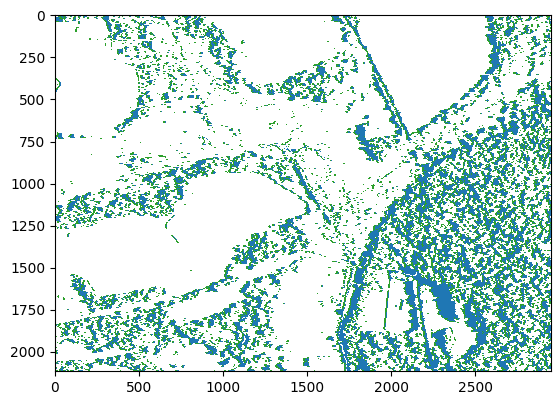

In [8]:
masks = np.zeros_like(shade)
masks = np.where(sunlit, 2, shade)

# 0 = unsampled, 1 = shade, 2 = sunlit
tab10 = colormaps['tab10']
cmap = colors.ListedColormap(["white", tab10(0.0), tab10(0.2)])

fig, ax = plt.subplots(1, 1)
ax.imshow(masks, cmap=cmap, interpolation='none')

plt.show()

In [9]:
# Write out the shadow mask and sun mask
out_shade = './results/shadow_mask.tif'
out_sun = './results/sunlit_mask.tif'

with rasterio.open(
    out_shade,
    'w',
    driver='GTiff',
    height=shade.shape[0],
    width=shade.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(shade, 1)
    
with rasterio.open(
    out_sun,
    'w',
    driver='GTiff',
    height=sunlit.shape[0],
    width=sunlit.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(sunlit, 1)

src.close()